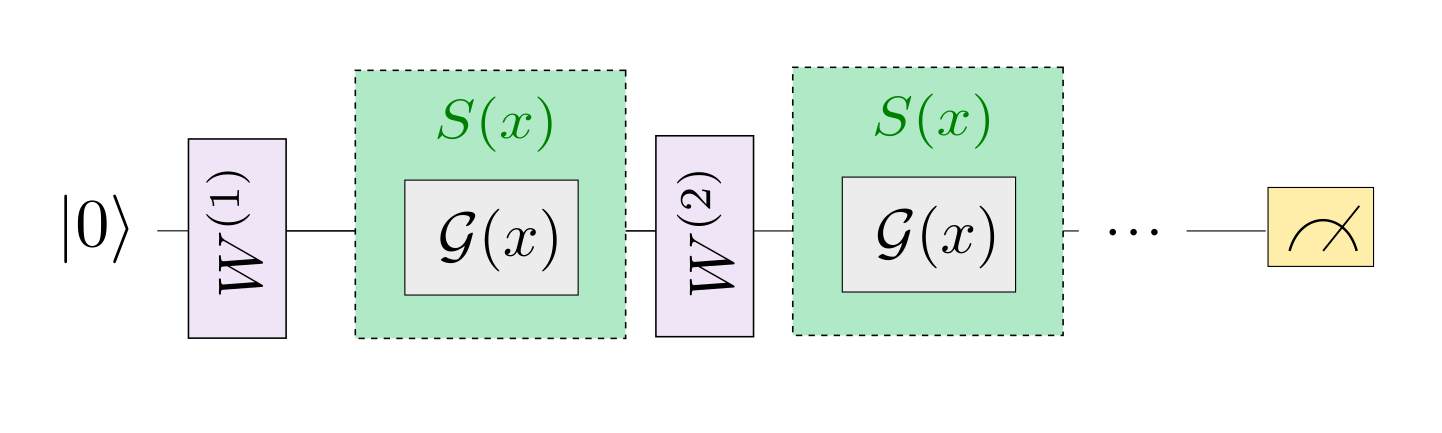

In [1]:
import pennylane as qml
import matplotlib.pyplot as plt
from pennylane import numpy as np

def loss(target, prediction):
  loss=0
  for t,p in zip(target, prediction):
    loss += 0.5*(t-p)**2
  loss = loss/len(target)
  return loss

$$g(x) = \sum_{n=-d}^d c_{n} e^{-nix}$$

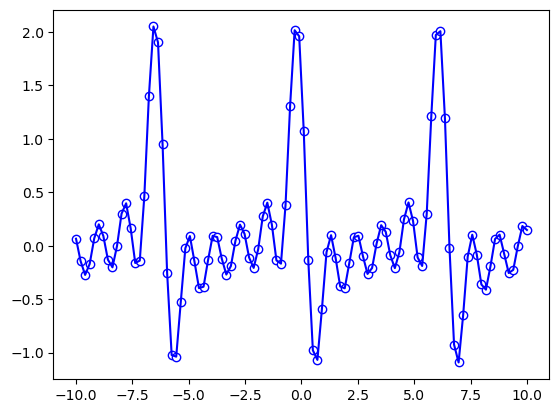

In [16]:
degree = 5
scaling = 1
c0 = 0.1
cn = [0.15+0.15j]*degree

def TargetFunc(x):
  res = c0
  for i,ci in enumerate(cn,start=1):
    expnt = np.complex128(scaling*i*x*1j)
    res1 = ci*np.exp(expnt)
    res2 = np.conjugate(res1)
    res += res1+res2
  return np.real(res)


x = np.linspace(-10,10,100,requires_grad=False)
ytarget = np.array([TargetFunc(X) for X in x],requires_grad=False)
plt.scatter(x,ytarget,facecolor='white',edgecolor='blue')
plt.plot(x,ytarget,c='blue')

plt.show()

In [17]:
dev = qml.device('default.qubit',wires=1)

def S(x):
    qml.RX(scaling*x,wires = 0)

def W(theta): 
    qml.Rot(theta[0],theta[1],theta[2],wires=0)

@qml.qnode(dev)
def QuModel(weights, x):
    for theta in weights[:-1]:
        W(theta)
        S(x)
    W(weights[-1])
    return qml.expval(qml.PauliZ(wires=0))

In [18]:
r = degree
#np.random.seed(42)
weights = 2*np.pi*np.random.random(size=(r+1,3),requires_grad = True)

yQuModel = [QuModel(weights,X) for X in x]
print(qml.draw(QuModel)(weights,x[-1]))

0: ──Rot(1.86,5.60,0.52)──RX(10.00)──Rot(2.52,3.32,3.31)──RX(10.00)──Rot(0.70,3.34,1.84)──RX(10.00)

───Rot(6.11,5.76,2.42)──RX(10.00)──Rot(3.12,0.00,2.17)──RX(10.00)──Rot(2.45,1.51,0.20)─┤  <Z>


In [19]:
def CostF(weights, x, y):
    prediction = [QuModel(weights,X) for X in x]
    return loss(y,prediction)

max_step = 100
opt = qml.AdamOptimizer(0.3)
batch_size = 30
cost = [CostF(weights, x, ytarget)]

In [20]:

for step in range(max_step):
    BatchIndex = np.random.randint(0,len(x),batch_size)
    xBatch = x[BatchIndex]
    yBatch = ytarget[BatchIndex]
    weights = opt.step(CostF,weights,xBatch,yBatch)[0]
    cst = CostF(weights, x, ytarget)
    cost.append(cst)
    if (step+1)%10 == 0:
        print('cost at step {0:3}: {1}'.format(step+1,cst))


cost at step  10: 0.1692361179563541
cost at step  20: 0.14263383930809076
cost at step  30: 0.15016960037083799
cost at step  40: 0.10861151658080502
cost at step  50: 0.10718510814549242
cost at step  60: 0.15245529209309838
cost at step  70: 0.10680956148916837
cost at step  80: 0.07744169337499578
cost at step  90: 0.07027906505803769
cost at step 100: 0.060441484453840726


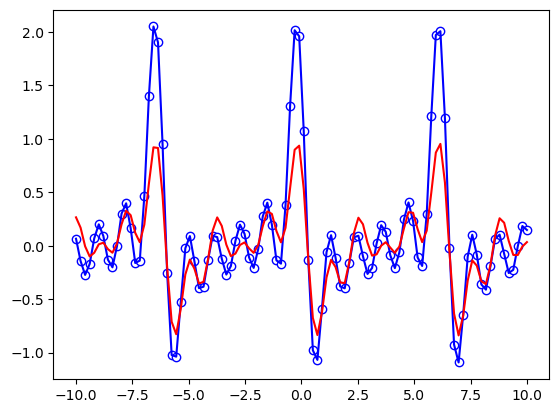

In [24]:
prediction = [QuModel(weights,X) for X in x]
plt.scatter(x,ytarget, facecolor='white', edgecolor='blue')
plt.plot(x,ytarget,c='blue')
#plt.scatter(x,prediction,facecolor='white',edgecolor='red')
plt.plot(x,prediction,c='red') 
 
plt.show()

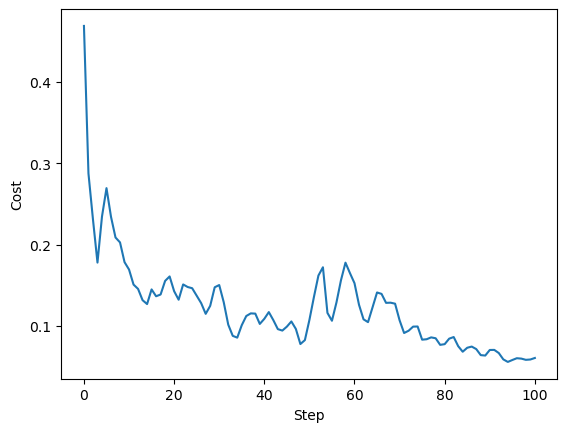

In [25]:
plt.plot(range(len(cost)),cost)
plt.ylabel('Cost')
plt.xlabel('Step')
plt.show()

In [26]:
dev.num_executions

13400